# 焦面图像仿真模块说明
## 简介
焦面仿真模块读取观测目标的坐标和光谱，结合星冕仪的光电效率曲线和点扩散函数等，生成焦面处以光电子为单位的图像。

本模块包括如下功能模块:
* 焦面图像生成功能
* 焦面掩膜功能

## 系统透过率功能

可以使用焦面仿真模块中的`filter_throughput`函数，计算星冕仪的系统透过率。该函数的输入参数为星冕仪观测波段名称（包括可见光波段有f565, f661, f743, f883, 近红外波段f940, f1265, f1425, f1542), 输出为星冕仪的系统的光电效率，包括望远镜和仪器的透过率，滤光片透过率，相机的量子效率。
光电效率的格式为`pysynphot`的`Throupghput`类，波长单位为$\AA$。

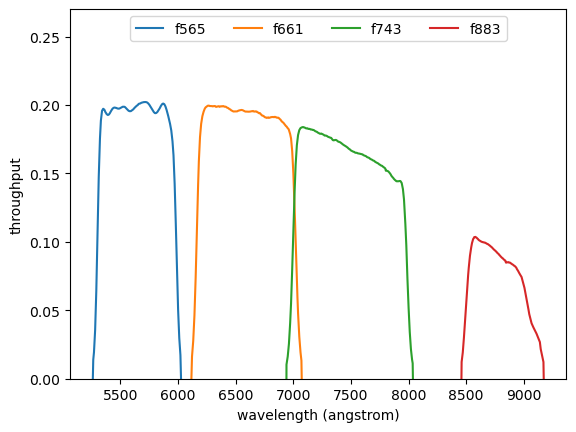

In [1]:
# from csst_cpic_sim.psf_simulation import simulate_psf
from csst_cpic_sim import star_photlam, spectrum_generator
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

from csst_cpic_sim.optics import filter_throughput
# f565 f661, f743, f883, f940, f1265, f1425, f1542
band_names = ['f565', 'f661', 'f743', 'f883']

for band_name in band_names:
    throughput = filter_throughput(band_name)
    plt.plot(throughput.wave, throughput.throughput, label=band_name)

plt.xlabel('wavelength (angstrom)')
plt.ylabel('throughput')
plt.ylim(0, 0.27)

#4 column legend
plt.legend(ncol=4, loc='upper center', bbox_to_anchor=(0.5, 1))


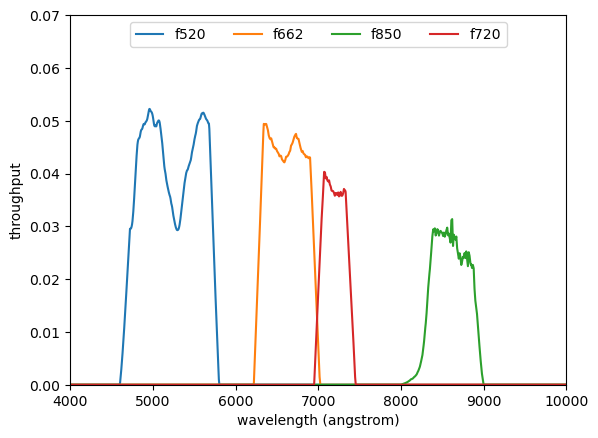

In [2]:
band_names = ['f520', 'f662', 'f850', 'f720']

for band_name in band_names:
    throughput = filter_throughput(band_name)
    plt.plot(throughput.wave, throughput.throughput, label=band_name)

plt.xlabel('wavelength (angstrom)')
plt.ylabel('throughput')
plt.ylim(0, 0.07)
plt.xlim([4000, 10000])

#4 column legend
plt.legend(ncol=4, loc='upper center', bbox_to_anchor=(0.5, 1))


## 焦面图像生成功能



`make_focus_image`函数是焦面图像生成功能的核心函数。该函数的输入参数为观测波段、观测坐标的位置和光谱、psf生成函数、输出为2D `np.array`格式的焦面图像，单位为光电子/像素/秒。

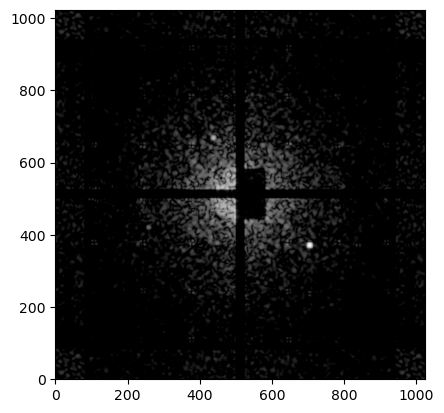

In [18]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from csst_cpic_sim.optics import filter_throughput, focal_convolve


# 生成一些恒星的位置和光谱
stars = [
    (5, 0, 0),
    (24, 0.5, 0.7),
    (15, 3.1, -2.3),
    (18, -1.2, 2.5),
    (21, -4.1, -1.5),
]

targets = []
for magnitude, x, y in stars:
    spectrum = star_photlam(
        magnitude=magnitude,
        sptype='G0V',
        is_blackbody='True',
    )
    targets.append([x, y, spectrum, None])

# 生成焦面图像
focal_img = focal_convolve('f661', targets, nsample=1)

def psf_imshow(psf):
    focal_img = psf.copy()
    focal_img = np.maximum(focal_img, 5e-3)
    # focal_img = np.minimum(focal_img, focal_img.max())
    image_log = np.log10(focal_img)
    plt.imshow(image_log, origin='lower', cmap='gray')

psf_imshow(focal_img)

通过`make_focus_image`函数的rotation参数，可以实现对焦面图像的旋转。rotation参数的单位为度，逆时针为正，顺时针为负。焦面旋转模拟观测过程中望远镜的滚动旋转。

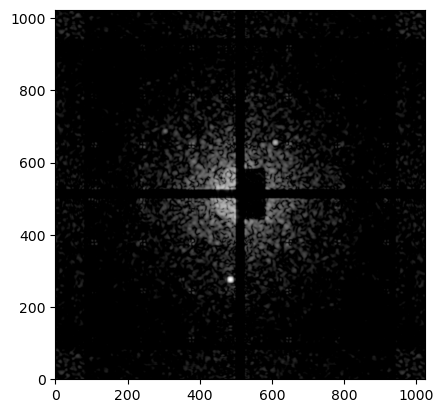

In [19]:
focal_img = focal_convolve('f661', targets, nsample=1, rotation=60)
psf_imshow(focal_img)

同样，可以通过`make_focus_image`函数的init_shift参数，实现对焦面图像的平移。init_shift参数的单位为角秒。模拟观测过程中将中央恒星偏移出视场中心的观测模式。

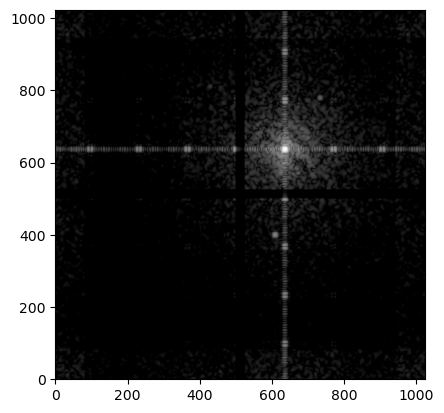

In [20]:
focal_img = focal_convolve('f661', targets, nsample=1, rotation=60, init_shifts=[2, 2])

psf_imshow(focal_img)